# Installing some libraries

In [300]:
# !pip install silence_tensorflow
# !apt-get install texlive-xetex
# !pip install nbconvert

# Importing Libraries

In [301]:
import tensorflow as tf
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, BatchNormalization, InputLayer
from tensorflow.keras.losses import Huber, MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import numpy as np
import warnings

In [302]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [303]:
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

# Data Preparation

In [304]:
df = pd.read_csv('train.csv', sep=',')

df.head()


,v.id,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
0,1,535651,798186,3,78945,1,2,14,177,73,123,351318.0
1,2,591911,861056,6,117220,5,9,9,148,74,95,285001.5
2,3,686990,770762,2,132538,2,8,15,181,53,97,215386.0
3,4,573999,722381,4,101065,4,3,11,197,54,116,244295.5
4,5,691388,811335,6,61559,3,9,12,160,53,105,531114.5


In [305]:
mean = df['current price'].mean()
std  = df['current price'].std()
print(mean)
print(std)
OW=1.1   # Weight of outliers, 5=(Inputting all of them)
lower_bound= mean - OW*std
upper_bound= mean + OW*std


308520.2425
126073.25914983758


In [306]:
filtered_df = df[(df['current price']>= lower_bound) & (df['current price']<=upper_bound)]

filtered_df.head()

,v.id,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
0,1,535651,798186,3,78945,1,2,14,177,73,123,351318.0
1,2,591911,861056,6,117220,5,9,9,148,74,95,285001.5
2,3,686990,770762,2,132538,2,8,15,181,53,97,215386.0
3,4,573999,722381,4,101065,4,3,11,197,54,116,244295.5
5,6,650007,844846,6,148846,2,9,13,138,61,109,177933.5


In [307]:
data   = tf.constant(filtered_df, dtype=tf.float32)
data   = tf.random.shuffle(data)
x_data = data[:, 3:-1]
y_data = data[:, -1]
y_data = tf.expand_dims(y_data, axis = -1)
print(y_data.shape)
print(x_data.shape)

(666, 1)
(666, 8)


# Data Visualization

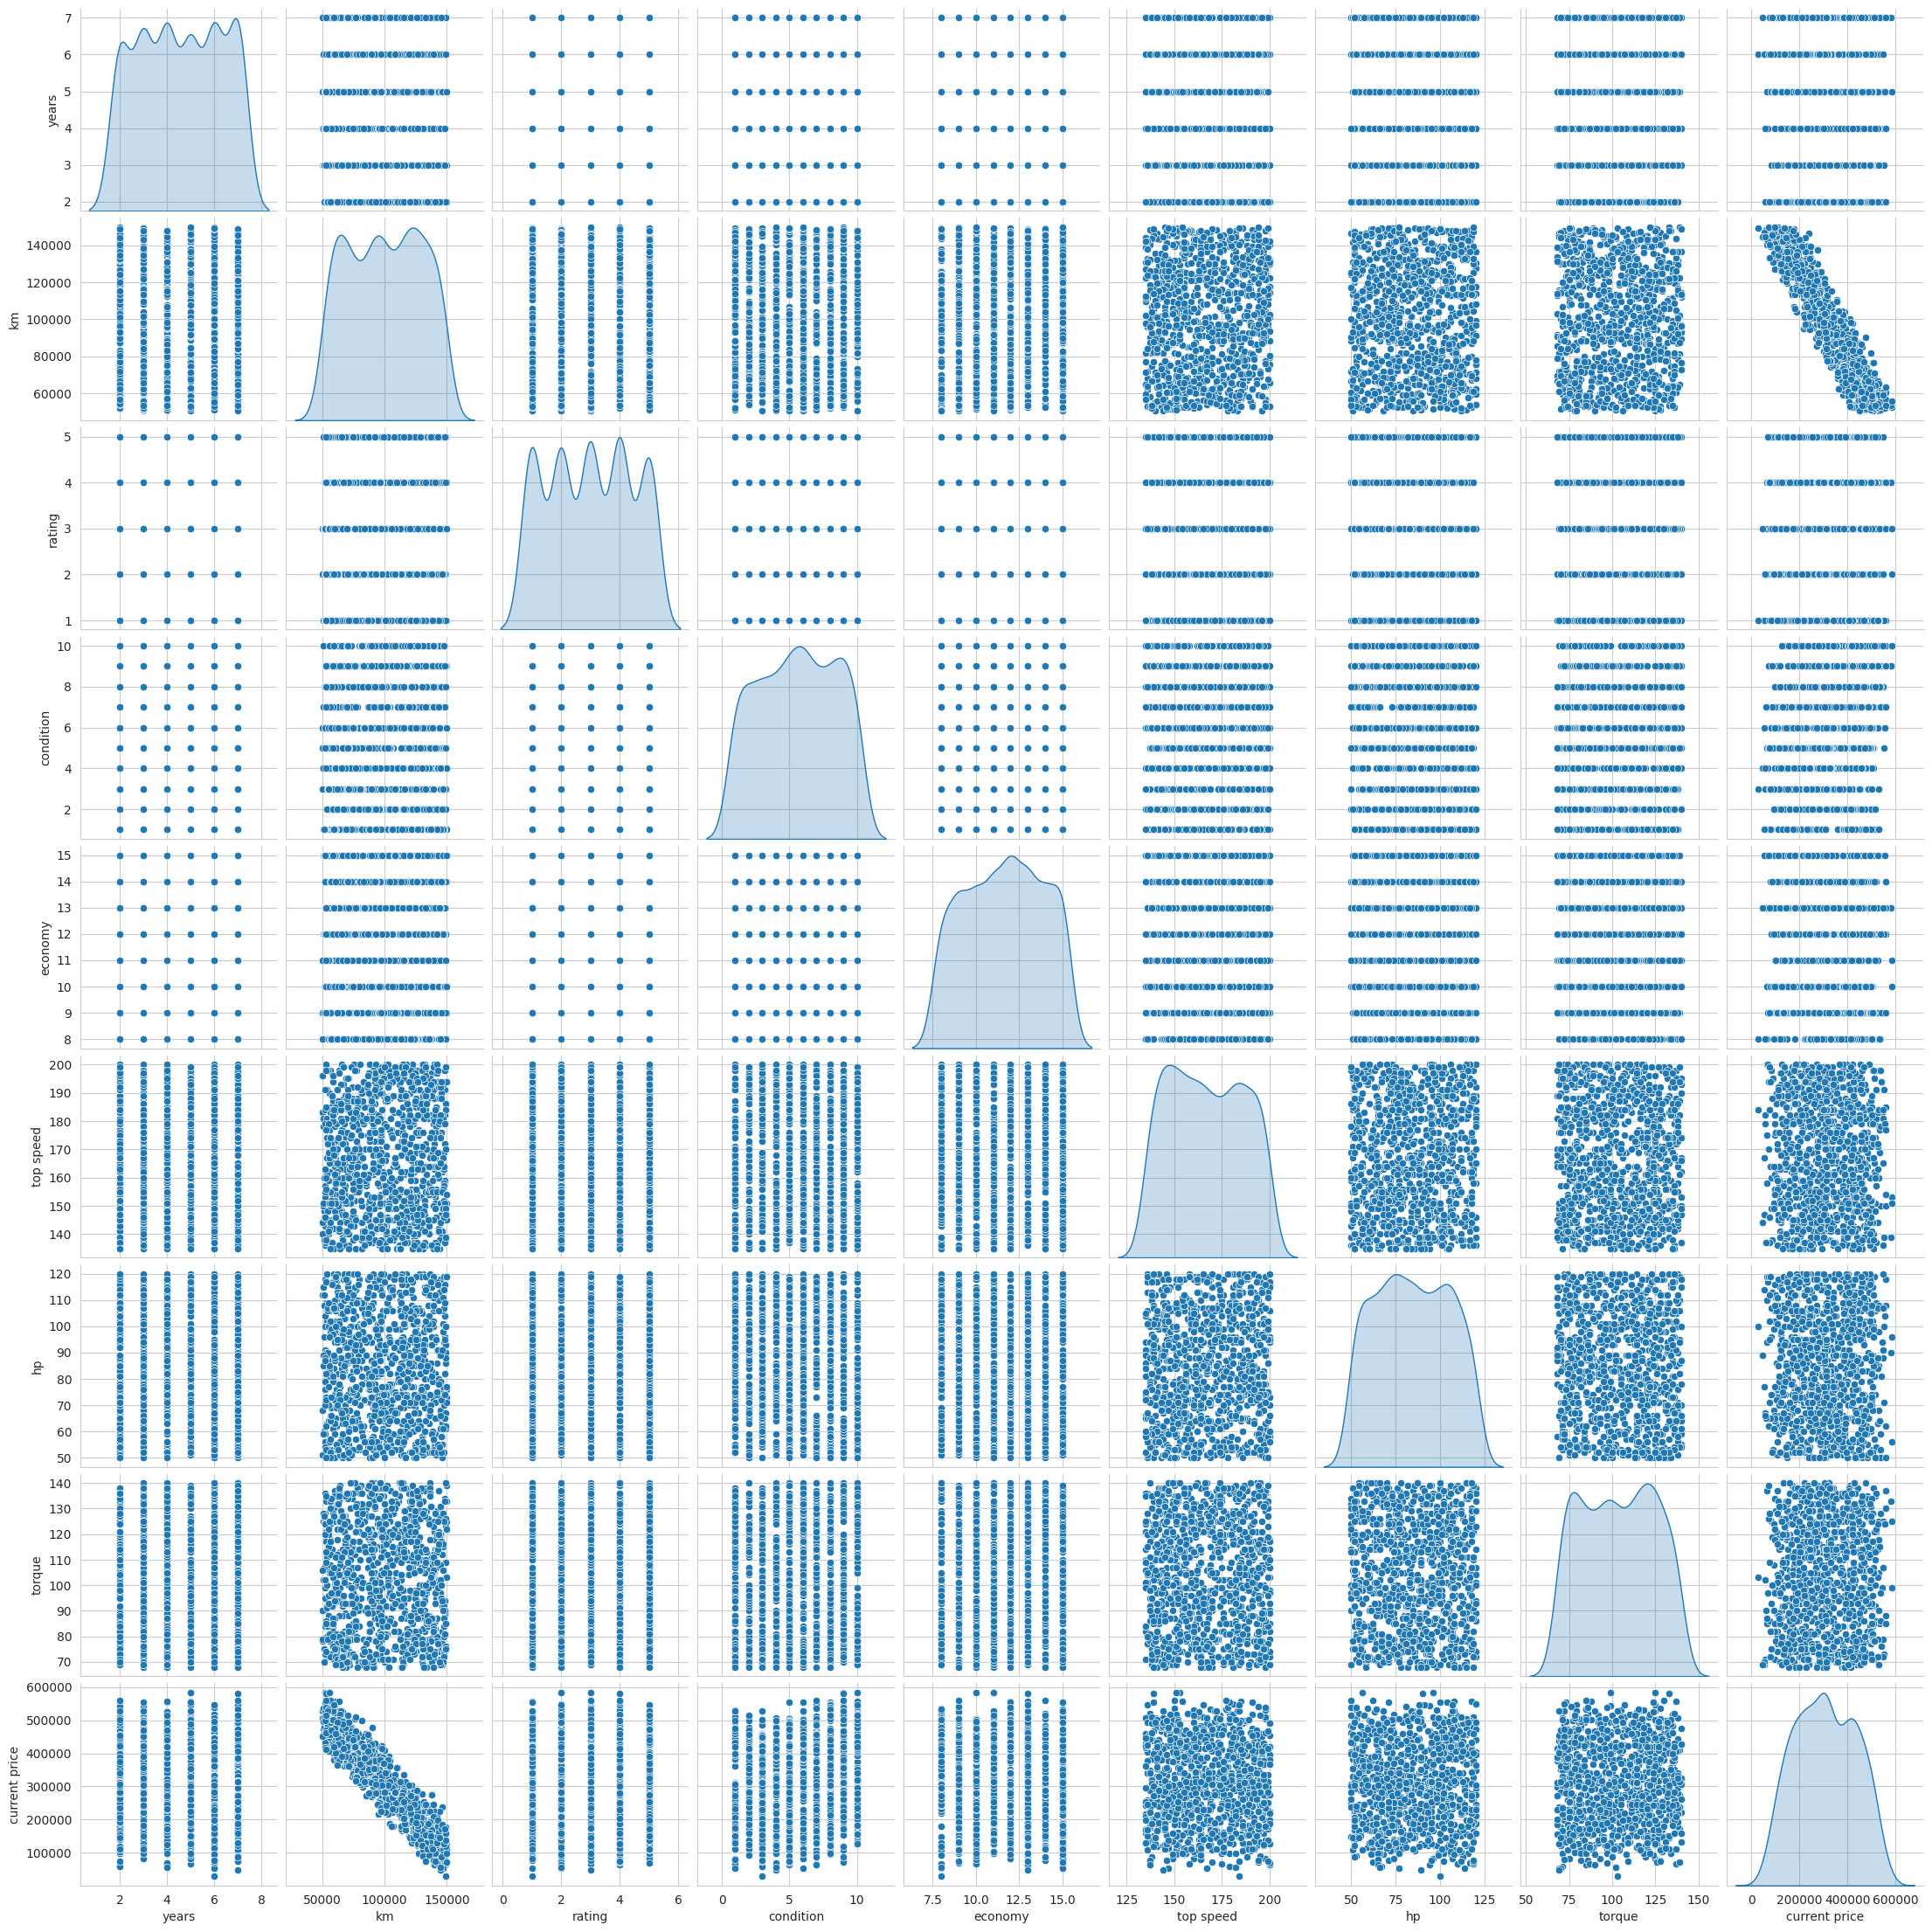

In [326]:
sns.pairplot(df[['years','km','rating','condition','economy','top speed','hp','torque','current price']], diag_kind='kde')

**More homogenous dataset after supressing outliers weight**

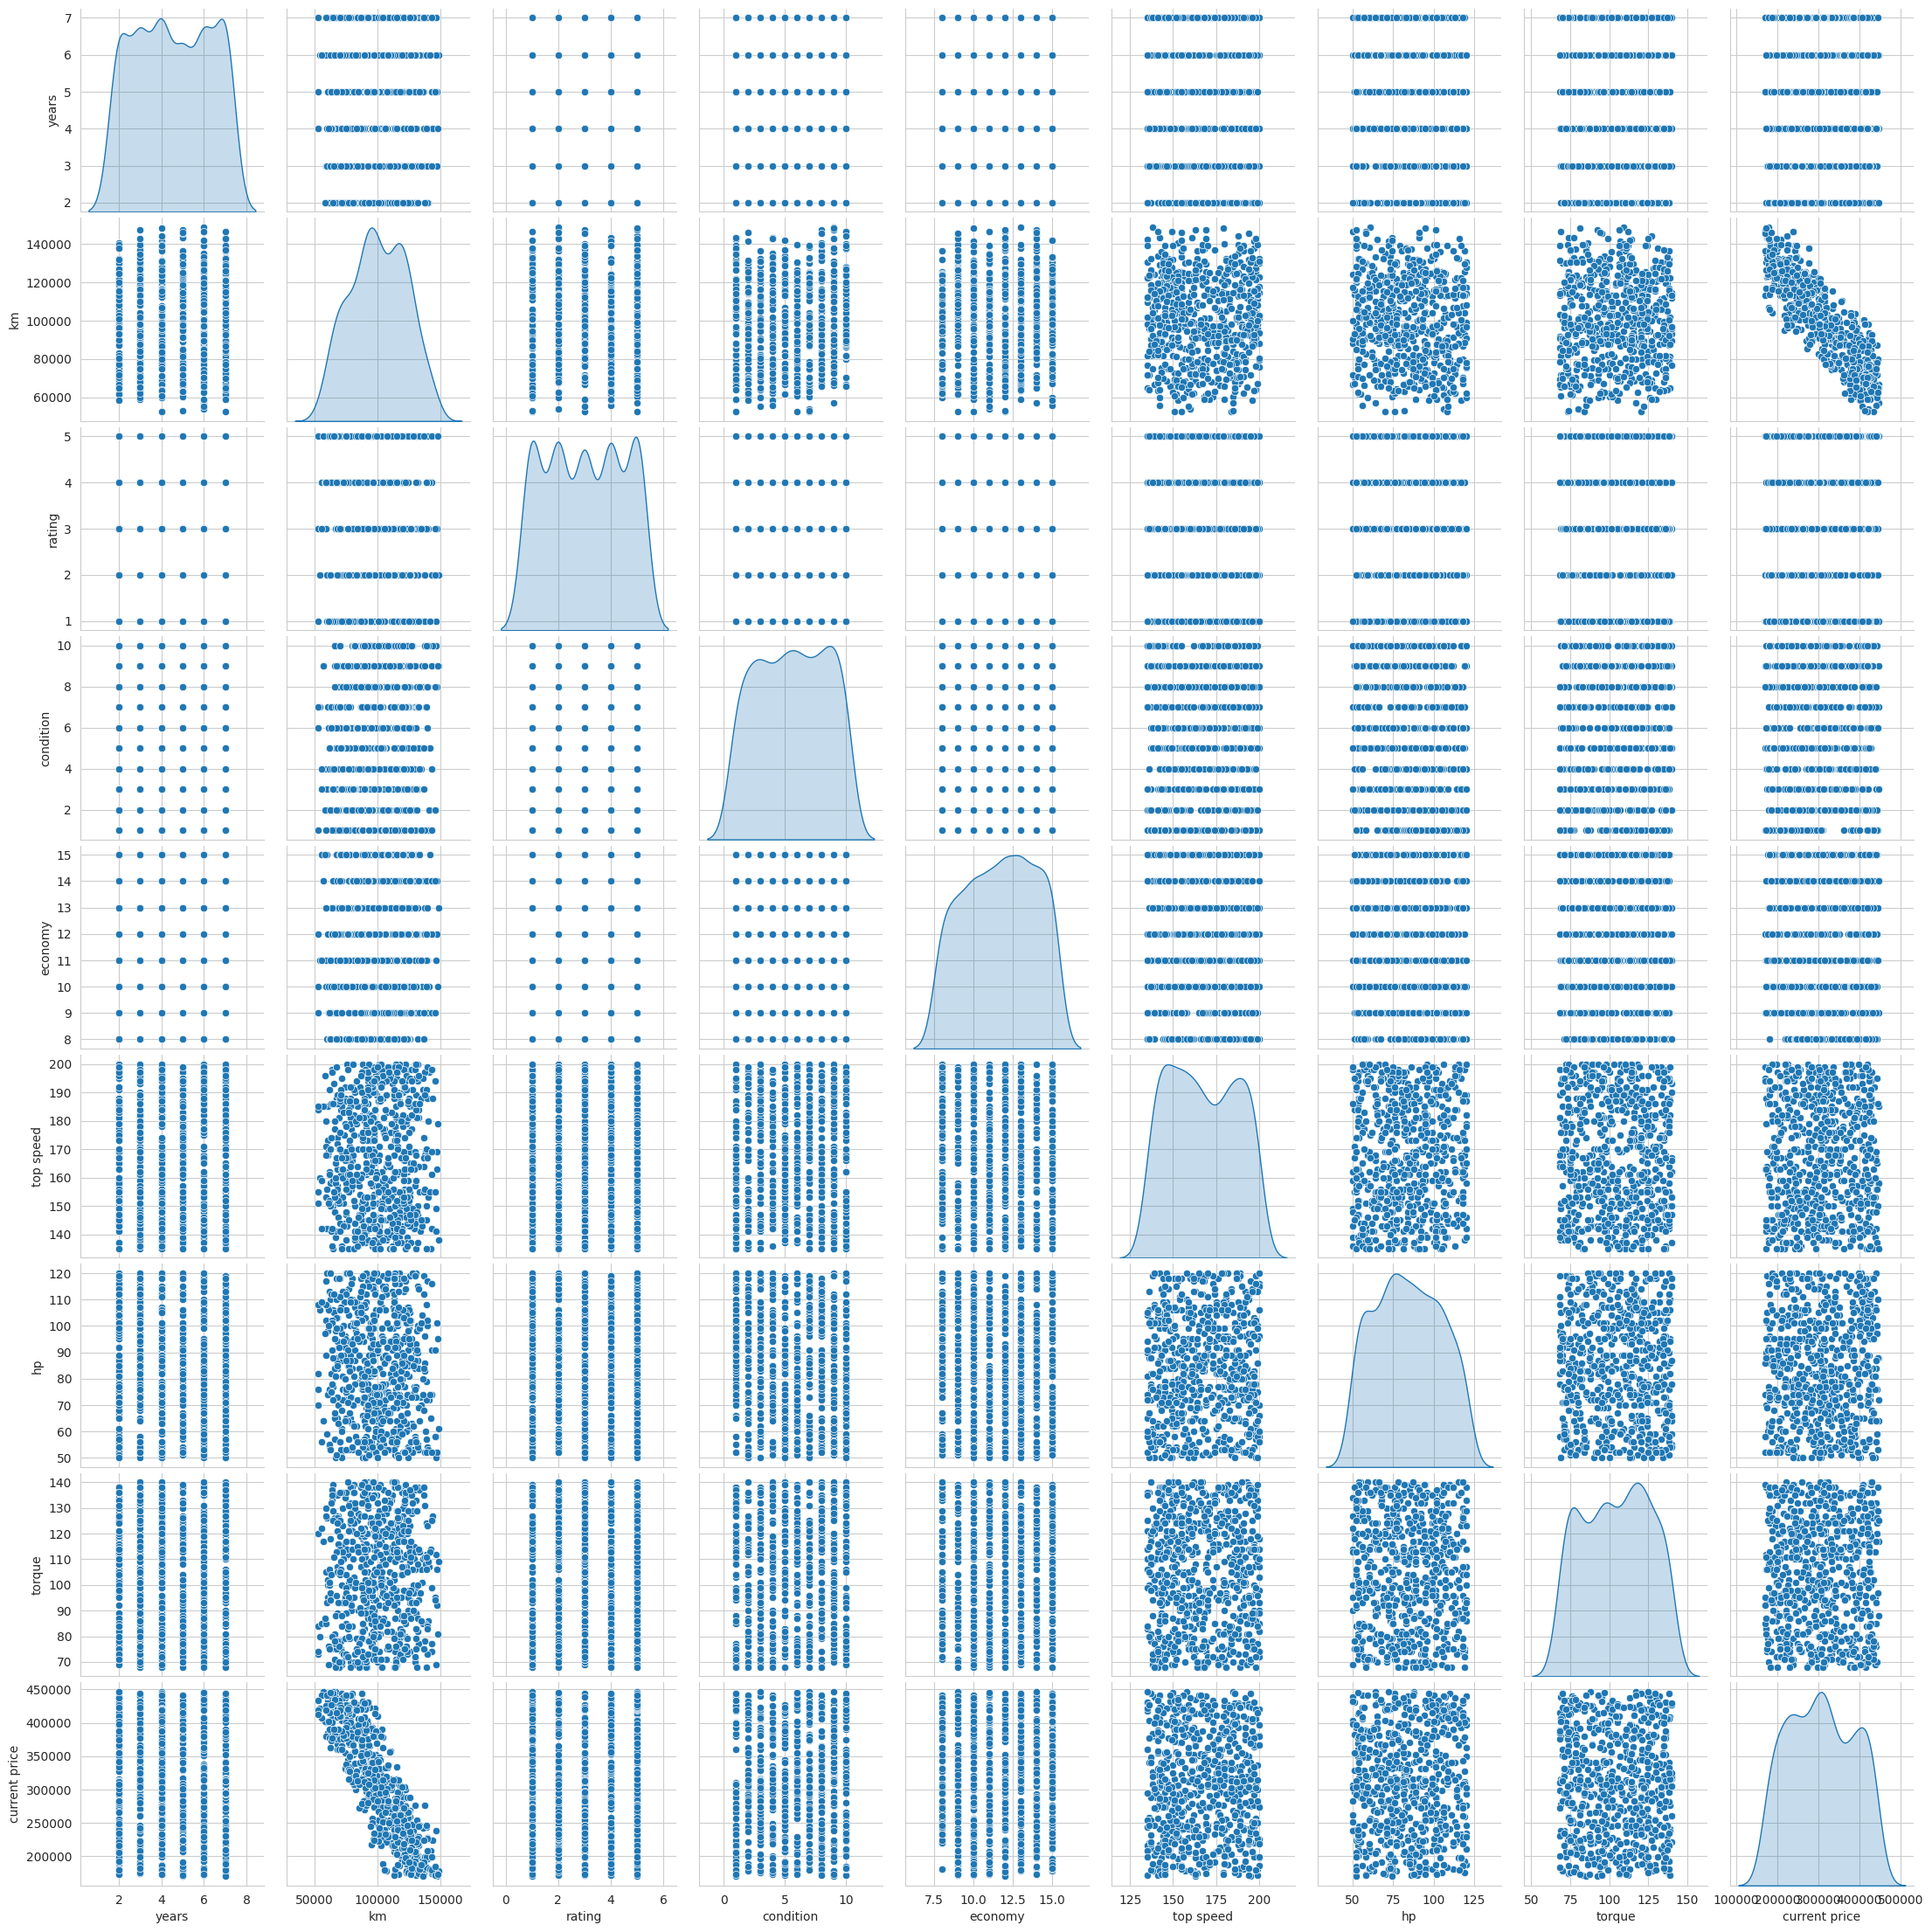

In [325]:
sns.pairplot(filtered_df[['years','km','rating','condition','economy','top speed','hp','torque','current price']], diag_kind='kde')

# Splitting Data

In [310]:
TrainRatio  = 0.8
ValRatio    = 0.1
TestRatio   = 0.1
DataSize    = len(y_data)
print(DataSize)

666


In [311]:
x_train = x_data[:int(DataSize*TrainRatio),:]
x_val   = x_data[int(DataSize*TrainRatio):int(DataSize*(TrainRatio+ValRatio)),:]
x_test  = x_data[int(DataSize*(TrainRatio+ValRatio)):int(DataSize*(TrainRatio+ValRatio+TestRatio)),:]
y_train = y_data[:int(DataSize*TrainRatio),:]
y_val   = y_data[int(DataSize*TrainRatio):int(DataSize*(TrainRatio+ValRatio)),:]
y_test  = y_data[int(DataSize*(TrainRatio+ValRatio)):int(DataSize*(TrainRatio+ValRatio+TestRatio)),:]

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(532, 8)
(67, 8)
(67, 8)
(532, 1)
(67, 1)
(67, 1)


# Model Creation

In [312]:
normalizer = BatchNormalization()
model= tf.keras.Sequential([
    InputLayer(input_shape=(8,)),
    normalizer,
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1),
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_7 (Bat  (None, 8)                 32        
 chNormalization)                                                
                                                                 
 dense_21 (Dense)            (None, 128)               1152      
                                                                 
 dense_22 (Dense)            (None, 32)                4128      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5345 (20.88 KB)
Trainable params: 5329 (20.82 KB)
Non-trainable params: 16 (64.00 Byte)
_________________________________________________________________


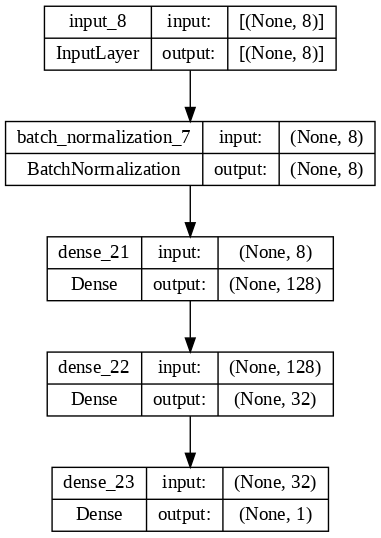

In [313]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=100)

In [314]:
checkpoint = ModelCheckpoint('MyModel.keras', save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=70)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

In [315]:
TrainData = tf.data.Dataset.from_tensor_slices((x_train,y_train))
ValData   = tf.data.Dataset.from_tensor_slices((x_val, y_val))
TestData  = tf.data.Dataset.from_tensor_slices((x_test, y_test))

TrainData = TrainData.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
ValData   = ValData.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
TestData  = TestData.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
model.compile(optimizer=Adam(learning_rate=0.01), loss=MeanAbsoluteError())

In [316]:
history = model.fit(TrainData, validation_data=ValData, epochs=500, callbacks=[earlystopping,checkpoint,reduce_lr])

Epoch 1/500
17/17 [==============================] - 1s 17ms/step - loss: 307272.6250 - val_loss: 306066.2188 - lr: 0.0100
Epoch 2/500
17/17 [==============================] - 0s 8ms/step - loss: 307096.8750 - val_loss: 303308.8438 - lr: 0.0100
Epoch 3/500
17/17 [==============================] - 0s 10ms/step - loss: 306016.9375 - val_loss: 290525.3125 - lr: 0.0100
Epoch 4/500
17/17 [==============================] - 0s 9ms/step - loss: 301048.7188 - val_loss: 250759.5781 - lr: 0.0100
Epoch 5/500
17/17 [==============================] - 0s 9ms/step - loss: 283938.2188 - val_loss: 159640.7188 - lr: 0.0100
Epoch 6/500
17/17 [==============================] - 0s 6ms/step - loss: 238381.2500 - val_loss: 91631.4375 - lr: 0.0100
Epoch 7/500
17/17 [==============================] - 0s 4ms/step - loss: 157864.5625 - val_loss: 226571.6719 - lr: 0.0100
Epoch 8/500
17/17 [==============================] - 0s 4ms/step - loss: 116611.4141 - val_loss: 233455.5156 - lr: 0.0100
Epoch 9/500
17/17 [====

In [317]:
model.evaluate(x_test,y_test)

3/3 [==============================] - 0s 4ms/step - loss: 25537.2344


25537.234375

# Plotting Results

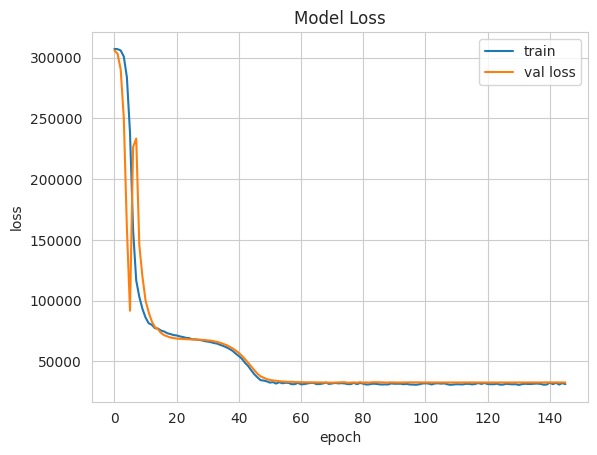

In [318]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val loss'])
plt.show()

In [319]:
y_pred=list(model.predict(x_test)[:,0])
y_true = list(y_test[:,0].numpy())


3/3 [==============================] - 0s 4ms/step


# **Closest Prediction**

In [320]:
x=0
min=float('inf')
for i,(pred,true) in enumerate(zip(y_pred,y_true)):
  diff=abs(pred-true)
  if(diff)<min:
    min=diff
    x=i

print(y_true[x],y_pred[x],x)

199798.0 198828.89 56


In [321]:
shape=tf.shape(y_test)[0]
print(shape.numpy())

67


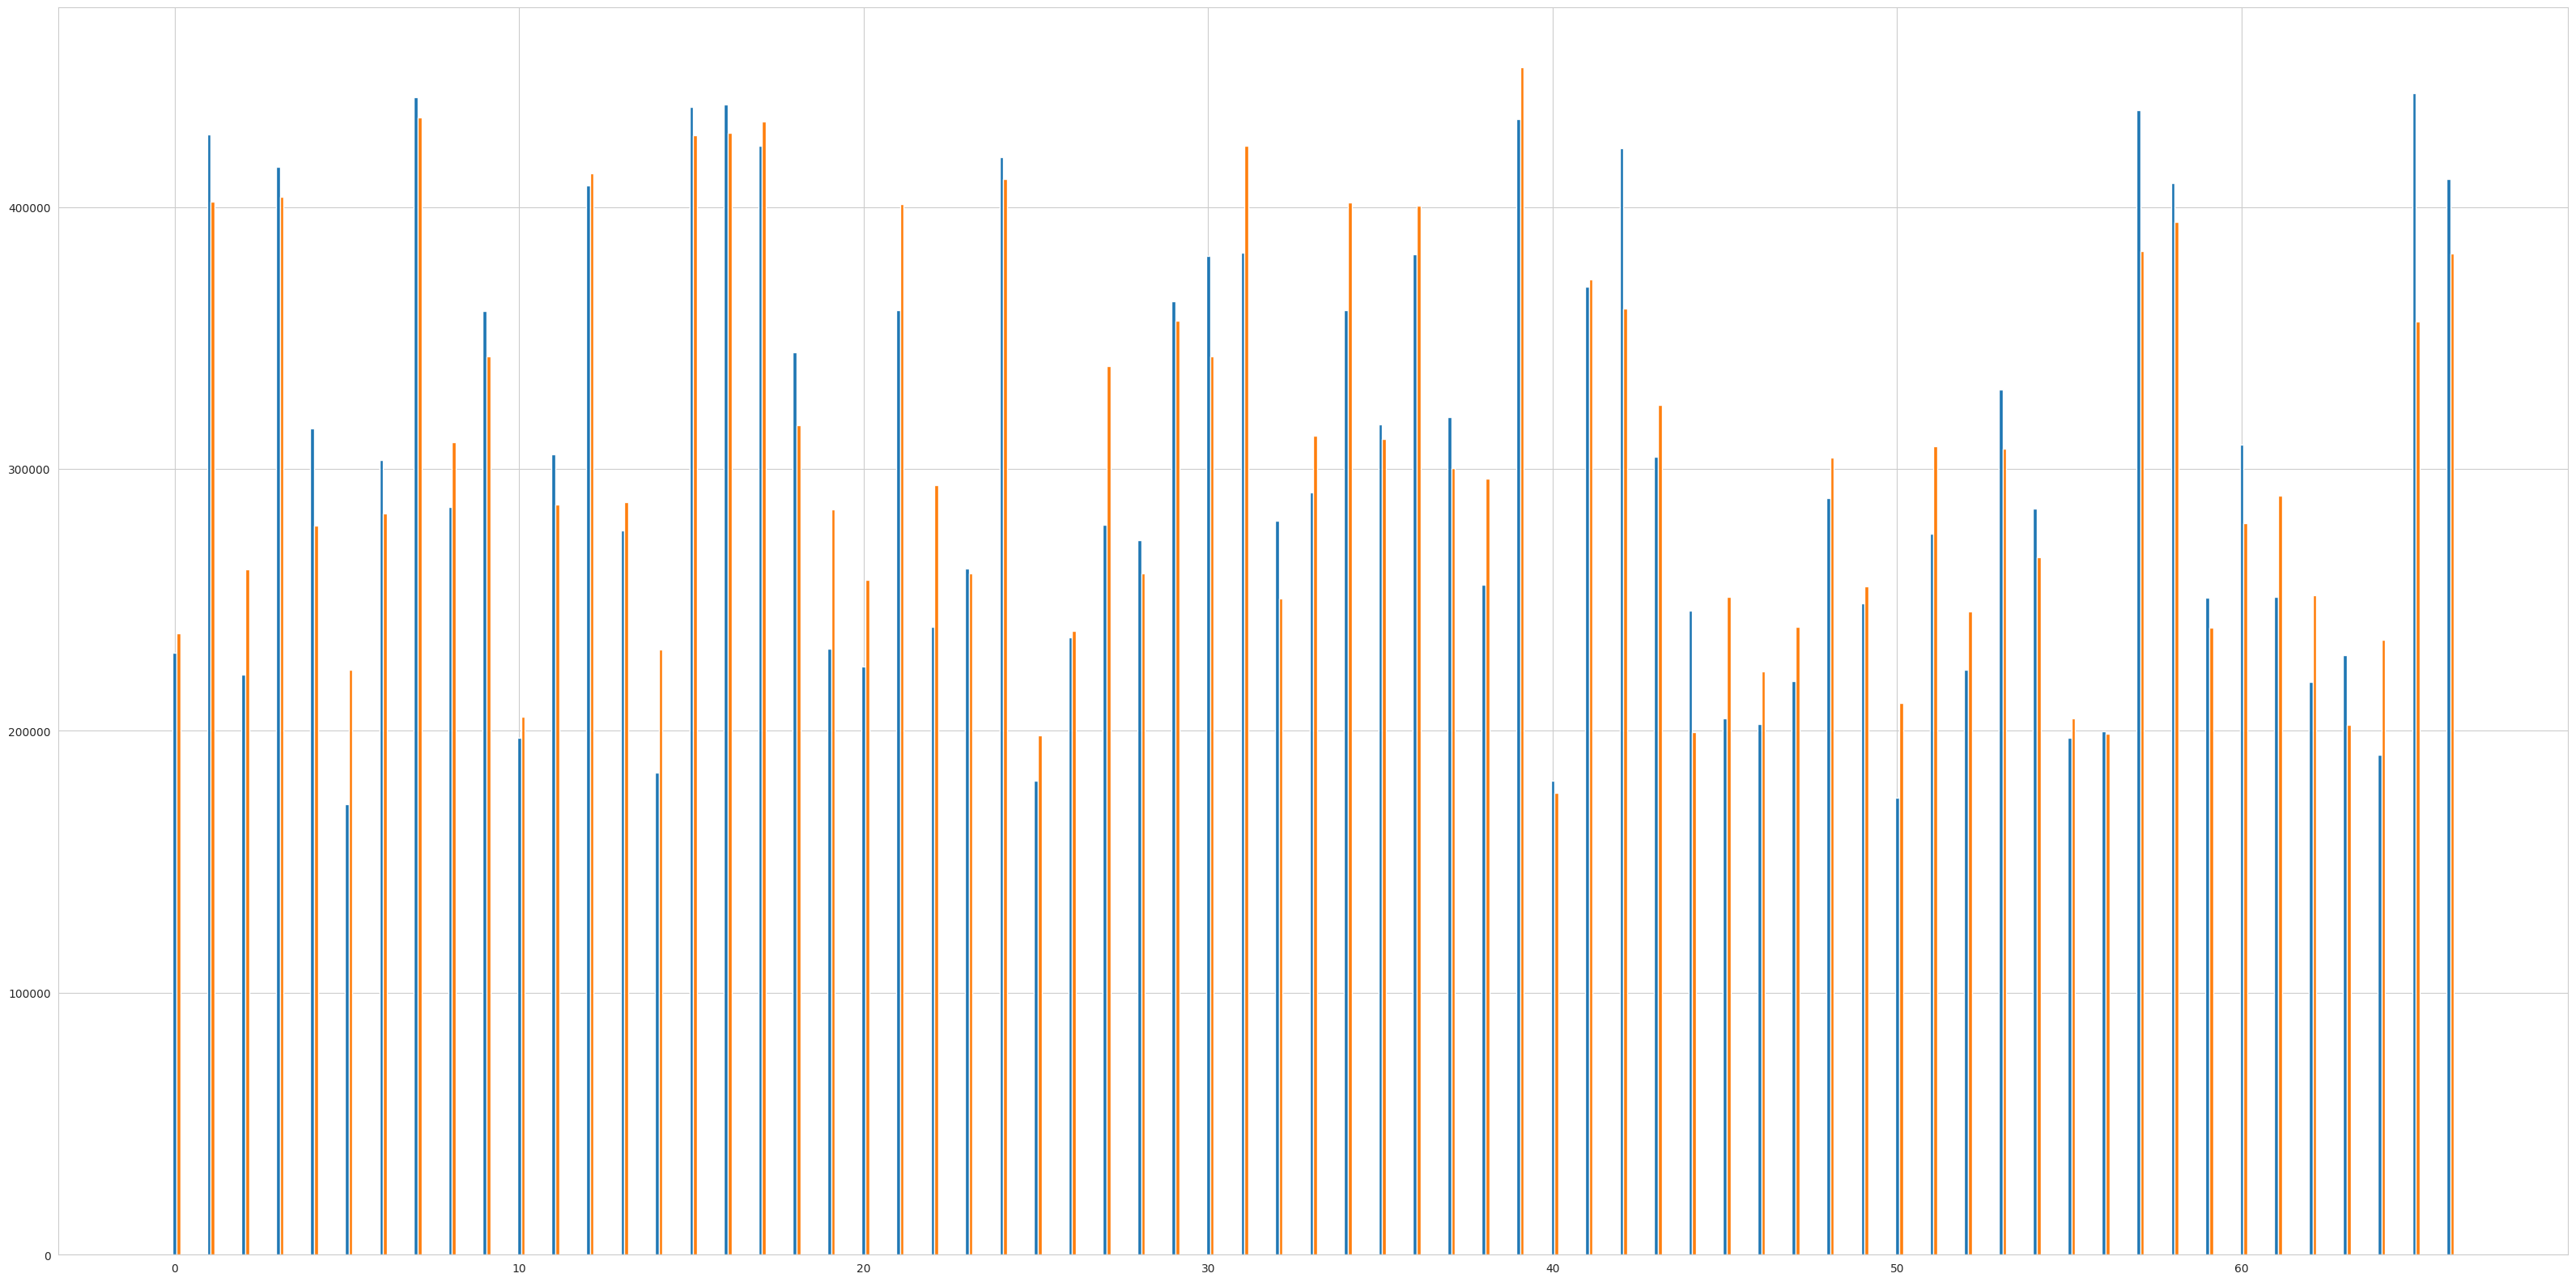

In [322]:

ind=np.arange(shape.numpy())
plt.figure(figsize=(40,20))
width=0.11
plt.bar(ind,y_true,width, label='true values')
plt.bar(ind+width,y_pred,width,label='predicted values')
plt.show()

# Sorting Layers by redundancy (least weights)

In [323]:
weights = []
Magnitudes = []
indexes = []
for layer in model.layers:
  if isinstance(layer, Dense):
    weights.append(layer.get_weights())

for weight in weights:
  Magnitudes.append(np.mean(np.abs(weight[0])))
  weights.pop()

for m in Magnitudes:
    least = np.argmin(Magnitudes)
    indexes.append(least)
    Magnitudes[least]=1000
print(indexes)

[1, 0]


In [324]:
!jupyter nbconvert --to pdf "/content/drive/MyDrive/Colab Notebooks/Untitled6.ipynb" --output-dir="/content/drive/MyDrive/Colab Notebooks/Output"


[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/Colab Notebooks/Untitled6.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--Jupy